In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.statespace.structural import UnobservedComponents
import pmdarima as pmd
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

#### 2. Missing Value Imputation by Kalman Smoothing with StructTS

In [6]:
sales_data = pd.read_excel("fake_data_m5.xlsx")

#replace 0 with NaN
sales_data["Sales"] = sales_data["Sales"].replace(0, np.nan)

Sales = sales_data["Sales"]


In [7]:
# Remove any missing values from the time series
Sales_ts_no_missing = Sales.dropna()

# Create a structural time series model with Kalman filtering
model = UnobservedComponents(Sales_ts_no_missing, 'local level')

# Fit the model to the data
fit_result = model.fit()

# Impute missing values using the fitted model
imputed_kalman_struct_ts = fit_result.predict(start=1, end=len(Sales))

print(imputed_kalman_struct_ts)


1        30.0
2        30.0
3        30.0
4        30.0
5        30.0
        ...  
1638    176.0
1639    176.0
1640    176.0
1641    176.0
1642    176.0
Name: predicted_mean, Length: 1642, dtype: float64


#### 3. Missing Value Imputation by Kalman Smoothing with auto.arima

In [4]:
import warnings
import numpy as np
import pandas as pd
import pmdarima as pmd
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

warnings.filterwarnings('ignore')

# Read the data
sales_data = pd.read_excel("fake_data_m5.xlsx")

# Replace zeros with NaN
sales_data["Sales"] = sales_data["Sales"].replace(0, np.nan)

# Create a boolean mask for observed values
observed_indices = ~sales_data["Sales"].isnull()

# Automatically select the best ARIMA model
autoarima_model = pmd.auto_arima(observed_indices, 
                                 seasonal=True, 
                                 trace=True,
                                 suppress_warnings=True,
                                 stepwise=True
                                 )

# Extract ARIMA parameters
order = autoarima_model.order

# Create a Kalman filter with ARIMA parameters
kalman_filter = KalmanFilter(
    k_endog=1,  # Number of endogenous variables
    k_states=order[0],
    k_posdef=order[1],
)

# Bind the observed sales data to the Kalman filter
observed_sales = sales_data.loc[observed_indices, "Sales"].values
kalman_filter.bind(observed_sales)  # Convert to NumPy array

# Initialize the state with the initial observed values
initial_state_mean = observed_sales[0] * np.ones(order[0])
initial_state_covariance = np.eye(order[0])
kalman_filter.initialize_known(initial_state_mean, initial_state_covariance)

# Fit the Kalman filter to the observed data
kalman_fit = kalman_filter.filter()

# Impute missing values using the fitted Kalman filter
imputed_kalman_arima_ts = kalman_fit.forecasts[0]

# Fill missing values in the original data
sales_data.loc[~observed_indices, "Sales"] = imputed_kalman_arima_ts[:len(sales_data) - np.sum(observed_indices)]

print(sales_data["Sales"])


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-1344.912, Time=1.95 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=243.418, Time=0.16 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1262.249, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-741.835, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=4537.183, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1297.517, Time=0.52 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1321.654, Time=1.17 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-1318.877, Time=2.13 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-1375.157, Time=1.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-1357.527, Time=0.75 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-1373.559, Time=2.05 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=-1373.776, Time=2.47 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=-1372.089, Time=1.70 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=-1371.294, Time=2.43 sec
 ARIMA(2,0,3)(0,0,0)[0]

In [5]:
imputed_kalman_arima_ts

array([0., 0., 0., ..., 0., 0., 0.])

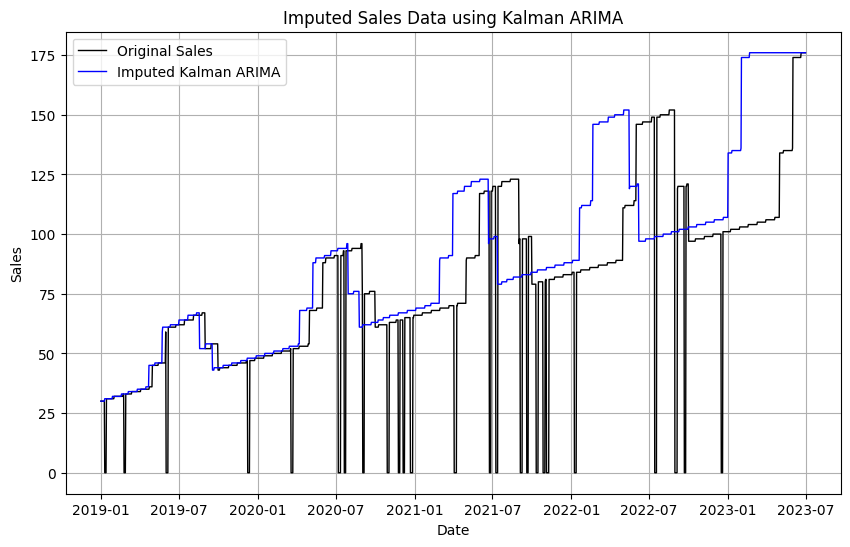

In [55]:
import matplotlib.pyplot as plt

# Plotting the graph
plt.figure(figsize=(10, 6))

# Plot the original data
plt.plot(sales_data["Date"], sales_data["Sales"], label="Original Sales", color="black", linewidth=1)

# Plot the imputed values
plt.plot(sales_data["Date"],imputed_kalman_struct_ts, label="Imputed Kalman ARIMA", color="blue", linewidth=1)

# Set plot title and labels
plt.title("Imputed Sales Data using Kalman ARIMA")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.legend()
plt.grid(True)

# Show plot
plt.show()